In [1]:
import re
import requests
import os
import sys
import string
import numpy as np
import pandas as pd
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.sklearn_api import W2VTransformer
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
dataframe = pd.read_excel('parsesber.xlsx')
df2 = pd.read_excel('ParseStrahZhiznTest.xlsx')

In [3]:
dataframe.tail(5)

,Дата_ответа_банка,Оценка,Отзыв_клиента,Ответ_банка
26704,15.01.2019 11:45,Без оценки,"Хотелось, что бы была банальная услуга связ...",Уважаемый SERGizmo!Благодарим Вас за предостав...
26705,06.01.2019 17:33,Без оценки,"Являюсь клиентом Сбербанк Премьер, соответст...","«общался со мной по электронной почте, быстро ..."
26706,10.01.2019 16:26,-,Приветствую. 24.08.2018. Моей соседкой был з...,"Уважаемый dariy0793!Меня зовут Юлия, я являюсь..."
26707,21.01.2019 23:05,-,Здравствуйте! 08.11.2018 наступил страховой ...,"Все выплатили, хотя и с задержкой."
26708,02.01.2019 20:21,1,"Была ипотека рт Сбербанка, в начале декабря ...",Спасибо за отзыв! В нашем рейтинге мы не оцени...


In [4]:
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def tokenize_ru(x):
    tokens = x.lower()
    tokens = re.sub(r'[^\w\s]+|[\d]',' ',tokens)
    tokens = word_tokenize(tokens)
    tokens = [i for i in tokens if (i not in string.punctuation)]
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', '—', '–', 'к', 'на', '...'])
    tokens = [i for i in tokens if (i not in stop_words)]
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]
    return tokens


def token_and_stem(text):
    tokens = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def token_only(text):
    tokens = [word.lower() for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    return filtered_tokens

def tok(x):
    z = re.sub(r'\s', '', x)
    return z

def repl(x):
    z =' '.join(x)
    return z

In [5]:
class normword2vec():     
    def transform(self, X, y=None, **fit_params):
        X = X.map(lambda x: tokenize_ru(x))
        return X
    

    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X, y, **fit_params)
        return self.transform(X)

    def fit(self, X, y=None, **fit_params):
        return self

In [6]:
class MeanVect(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(100)], axis=0)
            for words in X
        ])

In [7]:
dataframe['Отзыв_клиента1'] = dataframe['Отзыв_клиента'].map(lambda x: tokenize_ru(x))

In [8]:
data = []

In [9]:
dataclear = dataframe.loc[(dataframe['Оценка']!='-')&(dataframe['Оценка']!='Без оценки')&(dataframe['Оценка']!='Безоценки')&(dataframe['Оценка']!='-')&(dataframe['Оценка']!='')&(dataframe['Оценка']!=' ')]
dataclear2 = dataclear.drop(['Дата_ответа_банка','Ответ_банка'],axis='columns')
dataclear2 = dataclear2.reset_index(drop=True)
dataclear2['Оценка'] = dataclear2['Оценка'].map(lambda x: tok(x))
dataclear2['Оценка'] = dataclear2['Оценка'].map({'1':'0','2':'0','3':'1','4':'1','5':'1'})

In [10]:
dataclearv2 = df2.loc[(df2['Оценка']!='-')&(df2['Оценка']!='Без оценки')&(df2['Оценка']!='Безоценки')&(df2['Оценка']!='-')&(df2['Оценка']!='')&(df2['Оценка']!=' ')]
dataclearv2 = dataclearv2.reset_index(drop=True)
dataclearv2['Отзыв_клиента1'] = dataframe['Отзыв_клиента'].map(lambda x: tokenize_ru(x))
dataclearv2['Оценка'] = dataclearv2['Оценка'].map(lambda x: tok(x))
dataclearv2['Оценка'] = dataclearv2['Оценка'].map({'1':'0','2':'0','3':'1','4':'1','5':'1'})

In [11]:
dataclear2.head(15)

,Оценка,Отзыв_клиента,Отзыв_клиента1
0,0,Не соблюдение сроков снятия обременения посл...,"[соблюдение, сроков, снятия, обременения, выпл..."
1,0,У меня отличная кредитная история. Кредиты я...,"[отличная, кредитная, история, кредиты, беруре..."
2,0,02.03.2020 года в 13.11. в г. Долгопрудный б...,"[года, г, долгопрудный, проведена, сделка, ипо..."
3,0,"Очередная сделка в Сбербанке, и очередные пр...","[очередная, сделка, сбербанке, очередные, проб..."
4,0,10.03.2020 в 21:10 я произвёл внесение налич...,"[произвёл, внесение, наличных, банкомат, сберб..."
5,0,"сужусь с Ростелекомом. Оспорила взыскание, п...","[сужусь, ростелекомом, оспорила, взыскание, пр..."
6,1,"Сегодня посетила банк в посёлке Ильинский,ул...","[сегодня, посетила, банк, посёлке, ильинский, ..."
7,0,Здравствуйте. 25.02.2020 г. быд подписан кре...,"[здравствуйте, г, быд, подписан, кредитный, до..."
8,0,2 месяца выполнял задания бонусной программы...,"[месяца, выполнял, задания, бонусной, программ..."
9,0,мной проверена информация по исполнительному...,"[мной, проверена, информация, исполнительному,..."


In [77]:
y1 = dataclear2['Оценка']
X1 = dataclear2['Отзыв_клиента']

y2 = dataclear2['Оценка']
X2 = dataclear2['Отзыв_клиента1']

y_prov = dataclearv2['Оценка']
X_prov = dataclearv2['Отзыв_клиента']

X_train1,  X_test1, y_train1, y_test1 = model_selection.train_test_split(X1, y1, train_size=0.7,test_size=0.3,random_state = 0)
X_train2,  X_test2, y_train2, y_test2 = model_selection.train_test_split(X2, y2, train_size=0.7,test_size=0.3,random_state = 0)

In [78]:
model = Word2Vec(dataclear2['Отзыв_клиента1'])
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


In [79]:
xgb = XGBClassifier(max_depth=8,n_estimators=88)
sgd = SGDClassifier()

In [80]:
X_train2 = X_train2.reset_index(drop=True)
y_train2 = y_train2.reset_index(drop=True)

In [81]:
X_train3 = X_train2.map(lambda x: repl(x))
X_test3 = X_test2.map(lambda x: repl(x))

In [82]:
sgd_tfidf2 = Pipeline([
                     ('tfidf', TfidfVectorizer()),
                     ('sgd',sgd)
                     ])
 
sgd_tfidf2.fit(X_train3, y_train2)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
           

In [96]:
import pickle

In [97]:
filename = "C:/Users/User/Documents/PrPy/model/model_tdidf_sgd.sav"
pickle.dump(sgd_tfidf2, open(filename, 'wb'))

In [98]:
loaded_model = pickle.load(open(filename, 'rb'))
pred4 = loaded_model.predict(X_test3) 
pd.crosstab(y_test2, pred4)

col_0,0,1
Оценка,,
0,937,24
1,119,1032


(array([0.5, 1.5]), <a list of 2 Text xticklabel objects>)

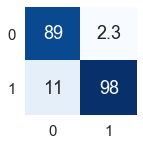

In [101]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 3, 3
plt.figure(figsize=(2,2))
sns.set(font_scale=1.5)
ax = sns.heatmap((pd.crosstab(y_test2, pred4).apply(lambda r: r/r.sum()*100, axis=0)), cbar=None, annot=True, cmap="Blues")
ax.set_ylabel("")
ax.set_xlabel("")
plt.yticks(rotation=0, size = 15)
plt.xticks(rotation=0, size = 15)

In [102]:
precision_recall_fscore_support(y_prov, predtest2, average='macro')

(0.9186229072957621, 0.9480967298110332, 0.9312419888011874, None)

In [103]:
predtest2 = loaded_model.predict(X_prov) 
pd.crosstab(y_prov, predtest2)

col_0,0,1
Оценка,,
0,497,18
1,86,1163


(array([0.5, 1.5]), <a list of 2 Text xticklabel objects>)

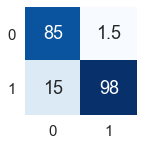

In [104]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 3, 3
plt.figure(figsize=(2,2))
sns.set(font_scale=1.5)
ax = sns.heatmap((pd.crosstab(y_prov, predtest2).apply(lambda r: r/r.sum()*100, axis=0)), cbar=None, annot=True, cmap="Blues")
ax.set_ylabel("")
ax.set_xlabel("")
plt.yticks(rotation=0, size = 15)
plt.xticks(rotation=0, size = 15)

In [105]:
precision_recall_fscore_support(y_prov, predtest2, average='macro')

(0.9186229072957621, 0.9480967298110332, 0.9312419888011874, None)

In [106]:
from sklearn.metrics import classification_report
report2 = classification_report(y_prov, predtest2, target_names=['0', '1'])
print(report2)

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       515
           1       0.98      0.93      0.96      1249

    accuracy                           0.94      1764
   macro avg       0.92      0.95      0.93      1764
weighted avg       0.95      0.94      0.94      1764



In [27]:
xgb_tfidf = Pipeline([
                     ('tfidf', TfidfVectorizer()),
                     ('xgb', xgb)
                     ])
 
xgb_tfidf.fit(X_train1, y_train1)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=8,
                        

In [28]:
pred1 = xgb_tfidf.predict(X_test1) 
pd.crosstab(y_test1, pred1)

col_0,0,1
Оценка,,
0,902,59
1,124,1027


In [29]:
#y_testbin = y_test1.map({'0':0,'1':1})
#y_testbin = y_test1

(array([0.5, 1.5]), <a list of 2 Text xticklabel objects>)

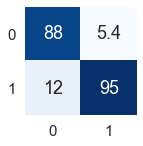

In [30]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 3, 3
plt.figure(figsize=(2,2))
sns.set(font_scale=1.5)
ax = sns.heatmap((pd.crosstab(y_test1, pred1).apply(lambda r: r/r.sum()*100, axis=0)), cbar=None, annot=True, cmap="Blues")
ax.set_ylabel("")
ax.set_xlabel("")
plt.yticks(rotation=0, size = 15)
plt.xticks(rotation=0, size = 15)

In [31]:
precision_recall_fscore_support(y_test1, pred1, average='macro') 

(0.9124072458617385, 0.9154366062718842, 0.9130476843335054, None)

In [32]:
param_gridXGB = {
       "n_estimators": [50,88,100,150,200],
       "max_depth": [3,6,8,9,11]
}

#param_gridCLF = {
#       "loss": ["","modified_huber", "huber", "epsilon_insensitive"],
#       "validation_fraction": [0.2, 0.25, 0.3, 0.35, 0,4]
#}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)

#grid_search = GridSearchCV(xgb,param_grid=param_gridXGB,scoring='roc_auc',cv=kfold)

In [33]:
xgb_word2vec = Pipeline([
              ("word2vec", MeanVect(w2v)),
               ('model_fitting',  xgb)]) 

xgb_word2vec.fit(X_train2, y_train2)

Pipeline(memory=None,
         steps=[('word2vec', <__main__.MeanVect object at 0x000002A767D9E4C8>),
                ('model_fitting',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=8,
                               min_child_weight=1, missing=None,
                               n_estimators=88, n_jobs=1, nthread=None,
                               objective='binary:logistic', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

In [34]:
pred2 = xgb_word2vec.predict(X_test2)
pd.crosstab(y_test2, pred2)

col_0,0,1
Оценка,,
0,919,42
1,153,998


(array([0.5, 1.5]), <a list of 2 Text xticklabel objects>)

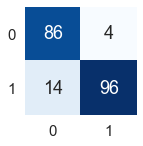

In [35]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 3, 3
plt.figure(figsize=(2,2))
sns.set(font_scale=1.5)
ax = sns.heatmap((pd.crosstab(y_test2, pred2).apply(lambda r: r/r.sum()*100, axis=0)), cbar=None, annot=True, cmap="Blues")
ax.set_ylabel("")
ax.set_xlabel("")
plt.yticks(rotation=0, size = 15)
plt.xticks(rotation=0, size = 15)

In [36]:
precision_recall_fscore_support(y_test2, pred2, average='macro') 

(0.9084457520091849, 0.9116838183509611, 0.9075410900425948, None)

In [37]:
sgd_tfidf = Pipeline([
                     ('tfidf', TfidfVectorizer()),
                     ('sgd',sgd)
                     ])
 
sgd_tfidf.fit(X_train1, y_train1)

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
           

In [38]:
pred3 = sgd_tfidf.predict(X_test1) 
pd.crosstab(y_test1, pred3)

col_0,0,1
Оценка,,
0,927,34
1,119,1032


(array([0.5, 1.5]), <a list of 2 Text xticklabel objects>)

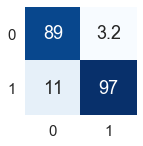

In [39]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 3, 3
plt.figure(figsize=(2,2))
sns.set(font_scale=1.5)
ax = sns.heatmap((pd.crosstab(y_test1, pred3).apply(lambda r: r/r.sum()*100, axis=0)), cbar=None, annot=True, cmap="Blues")
ax.set_ylabel("")
ax.set_xlabel("")
plt.yticks(rotation=0, size = 15)
plt.xticks(rotation=0, size = 15)

In [40]:
precision_recall_fscore_support(y_test1, pred3, average='macro') 

(0.9271691676322558, 0.9306159146776409, 0.9273773187618707, None)

In [41]:
predtest = sgd_tfidf.predict(X_prov) 
pd.crosstab(y_prov, predtest)

col_0,0,1
Оценка,,
0,498,17
1,87,1162


(array([0.5, 1.5]), <a list of 2 Text xticklabel objects>)

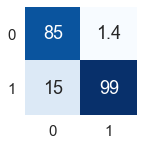

In [42]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 3, 3
plt.figure(figsize=(2,2))
sns.set(font_scale=1.5)
ax = sns.heatmap((pd.crosstab(y_prov, predtest).apply(lambda r: r/r.sum()*100, axis=0)), cbar=None, annot=True, cmap="Blues")
ax.set_ylabel("")
ax.set_xlabel("")
plt.yticks(rotation=0, size = 15)
plt.xticks(rotation=0, size = 15)

In [43]:
precision_recall_fscore_support(y_prov, predtest, average='macro')

(0.9184315260651139, 0.9486672833412361, 0.9313104687734013, None)

In [44]:
from sklearn.metrics import classification_report
report = classification_report(y_prov, predtest, target_names=['0', '1'])
print(report)

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       515
           1       0.99      0.93      0.96      1249

    accuracy                           0.94      1764
   macro avg       0.92      0.95      0.93      1764
weighted avg       0.95      0.94      0.94      1764



In [45]:
sgd_word2vec = Pipeline([
            # ('selectword2vec',  normword2vec()),
              ("word2vec", MeanVect(w2v)),
               ('model_fitting',  sgd)]) 

sgd_word2vec.fit(X_train2, y_train2)

Pipeline(memory=None,
         steps=[('word2vec', <__main__.MeanVect object at 0x000002A768223F48>),
                ('model_fitting',
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000, n_iter_no_change=5, n_jobs=None,
                               penalty='l2', power_t=0.5, random_state=None,
                               shuffle=True, tol=0.001, validation_fraction=0.1,
                               verbose=0, warm_start=False))],
         verbose=False)

In [46]:
pred4 = sgd_word2vec.predict(X_test2)
pd.crosstab(y_test2, pred4)

col_0,0,1
Оценка,,
0,924,37
1,148,1003


(array([0.5, 1.5]), <a list of 2 Text xticklabel objects>)

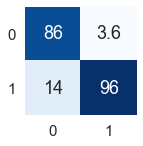

In [47]:
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 3, 3
plt.figure(figsize=(2,2))
sns.set(font_scale=1.5)
ax = sns.heatmap((pd.crosstab(y_test2, pred4).apply(lambda r: r/r.sum()*100, axis=0)), cbar=None, annot=True, cmap="Blues")
ax.set_ylabel("")
ax.set_xlabel("")
plt.yticks(rotation=0, size = 15)
plt.xticks(rotation=0, size = 15)

In [48]:
precision_recall_fscore_support(y_test2, pred4, average='macro') 

(0.9131816877152699, 0.9164572994934505, 0.912282572604513, None)

In [1]:
#Кластеризация

In [2]:
import re
import requests
import os
import sys
import string
import numpy as np
import pandas as pd
from gensim.test.utils import common_texts, get_tmpfile

from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, RobustScaler

In [4]:
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("russian")
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [37]:
#dfClaster = pd.read_excel('ParseNegative.xlsx')
dfClaster = pd.read_excel('parsesber.xlsx')

In [38]:
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def tokenize_ru(x):
    tokens = x.lower()
    tokens = re.sub(r'[^\w\s]+|[\d]',' ',tokens)
    tokens = word_tokenize(tokens)
    tokens = [i for i in tokens if (i not in string.punctuation)]
    stop_words = stopwords.words('russian')
    stop_words.extend(['что', 'это', 'так', 'вот', 'быть', 'как','ко','ту','р','года','год','здравствуйте','в', '—', '–', 'к','.',',','г',' г','ч',' ч', 'на', '...',' около','около'])
    tokens = [i for i in tokens if (i not in stop_words)]
    tokens = [i.replace("«", "").replace("»", "") for i in tokens]
    return tokens


def token_and_stem(text):
    tokens = [word for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def token_only(text):
    tokens = [word.lower() for sent in sent_tokenize(text) for word in word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            token = re.sub(r'[^\w\s]+|[\d]',' ',token)
            filtered_tokens.append(token)
    return filtered_tokens

def tok(x):
    z = re.sub(r'\s', '', x)
    return z

In [39]:
dfclall = dfClaster['Отзыв_клиента']

In [40]:
stopwords = stopwords.words('russian')

In [41]:
stopwords.extend(['итоге','нам','прошу','руб','которые','клиентов','могу','ещё','клиентом','являюсь','мои','день','итоге','рублей','просто','почему','время','очень','дней','лет','вопрос','сегодня','нужно','сказали','г ','хотя','добрый','который','вообще','что', 'это','лет', 'так', 'вот','.',',', 'быть', 'как','ко','ту','р','года','год','здравствуйте','в', '—', '–', 'к','г',' г','ч',' ч', 'на', '...',' около','около'])

tfidf_vectorizer = TfidfVectorizer(smooth_idf=True,max_df=0.6,min_df=0.01,max_features=100000,
                                   stop_words=stopwords,
                                   use_idf=True,tokenizer=token_only, ngram_range=(1,3))

#tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
 #                                  min_df=0.01, stop_words=stopwords,
  #                                 use_idf=True, tokenizer=token_only, ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(dfclall)

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from sklearn.cluster import KMeans

In [43]:
from sklearn.cluster import KMeans

kmeans = KMeans().fit(tfidf_matrix)
y_kmeans = kmeans.predict(tfidf_matrix)

In [44]:
from sklearn.cluster import MiniBatchKMeans

mbk  = MiniBatchKMeans(n_clusters=8,init='random').fit(tfidf_matrix)
y_kmeansMB = mbk.predict(tfidf_matrix)

In [45]:
from sklearn.cluster import AgglomerativeClustering

agglo = AgglomerativeClustering(n_clusters=8,affinity='euclidean')
y_aglo = agglo.fit_predict(tfidf_matrix.toarray())

In [46]:
X = tfidf_matrix
y = y_kmeans

N = 50
# индексы топ 50 столбцов с максимальной суммой элементов (в столбцах)
idx = np.ravel(X.sum(axis=0).argsort(axis=1))[::-1][:N]
top_50_words = np.array(tfidf_vectorizer.get_feature_names())[idx].tolist()

In [47]:
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(tfidf_matrix)
#_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(tfidf_matrix)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

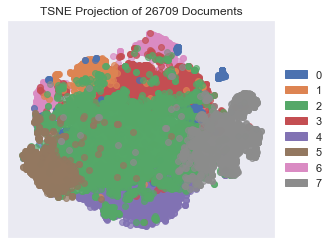

In [48]:
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer()
tsne.fit(tfidf_matrix, y_kmeans)
tsne.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

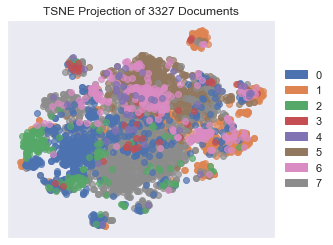

In [35]:
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer()
tsne.fit(tfidf_matrix, y_kmeansMB)
tsne.show()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

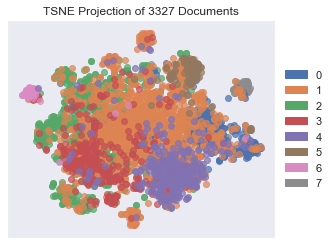

In [36]:
from yellowbrick.text import TSNEVisualizer
tsne = TSNEVisualizer()
tsne.fit(tfidf_matrix, y_aglo)
tsne.show()

In [302]:
#f, (ax1) = plt.subplots(1, figsize=(12, 8))
#f.suptitle('Кластеризация KMeans', fontsize=20)

#blue_patch = mpatches.Patch(color='#0A0AFF', label='0')
#red_patch = mpatches.Patch(color='#AF0000', label='1')

#ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=y_kmeans, linewidths=2,cmap='gist_rainbow')
#ax1.set_title('KMeans+TSNE', fontsize=20)
#ax1.grid(True)

#ax1.legend(handles=[red_patch,blue_patch,green_patch])
#plt.show()

In [303]:
l1 = [] 
l1 = [el for el in y_kmeans]
d1 = {"clustersKM": l1}
dfKM = pd.DataFrame(d1)

In [304]:
l2 = [] 
l2 = [el for el in y_kmeansMB]
d2 = {"clustersMB": l2}
dfMB = pd.DataFrame(d2)

In [305]:
l3 = [] 
l3 = [el for el in y_aglo]
d3 = {"clustersAGG": l3}
dfAGG = pd.DataFrame(d3)

In [306]:
#df = pd.concat([dfClasterP,dfKM,dfMB,dfDB,dfAGG], axis=1)
df = pd.concat([dfClaster,dfKM,dfMB,dfAGG], axis=1)

In [307]:
df.head(10)

,Дата_ответа_банка,Оценка,Отзыв_клиента,Ответ_банка,clustersKM,clustersMB,clustersAGG
0,-,1,Не соблюдение сроков снятия обременения посл...,-,2,6,5
1,-,Без оценки,6 марта 2020г около 12ч решила перевести ден...,-,6,0,2
2,-,1,У меня отличная кредитная история. Кредиты я...,-,0,2,0
3,-,Без оценки,6.03.20 я обратился в банк с заявлением №20...,-,5,7,6
4,-,Без оценки,"Я, Смирнова Ирина Федоровна, клиент ПАО «Сбе...",-,4,0,4
5,-,Без оценки,"Внезапно узнала, что если вы вкладчик Сберба...",-,0,0,2
6,-,1,02.03.2020 года в 13.11. в г. Долгопрудный б...,-,2,6,0
7,-,1,"Очередная сделка в Сбербанке, и очередные пр...",-,2,6,0
8,-,1,10.03.2020 в 21:10 я произвёл внесение налич...,-,3,7,2
9,-,1,"сужусь с Ростелекомом. Оспорила взыскание, п...",-,4,7,2


In [308]:
df.to_excel('Claster3ALL.xlsx', sheet_name='Sheet1')

In [71]:
#Кластеризация LDA

In [82]:
import re
import requests
import os
import sys
import string
import numpy as np
import pandas as pd

In [83]:
dfClaster = pd.read_excel('ParseNegative.xlsx')

In [84]:
from nltk.corpus import stopwords
import re, string
from nltk.stem.snowball import SnowballStemmer

stopwords = stopwords.words("russian")
stopwords.extend(['итоге','нам','№','000','прошу','руб','которые','клиентов','могу',
                  'ещё','клиентом','являюсь','мои','день','итоге','рублей','просто',
                  'почему','время','очень','дней','лет','вопрос','сегодня','нужно',
                  'сказали','г ','хотя','добрый','который','вообще','что', 'это','лет',
                  'так', 'вот','.',',', 'быть', 'как','ко','ту','р','года','год','здравствуйте',
                  'в', '—', '–', 'к','г',' г','ч',' ч', 'на', '...',' около','около'])
regex = re.compile('[%s]' % re.escape(string.punctuation))
stemmer = SnowballStemmer("russian")

def preproc(text):
    text = regex.sub('', text)  # удаляем пунктуацию
    text = [token for token in text.split() if token not in stopwords] # Удаляем стоп слова
    text = [stemmer.stem(token) for token in text] # Выполняем стэмминг
    text = [token for token in text if token] # Удаляем пустые токены
    return ' '.join(text)

In [85]:
dfClaster['Отзыв_клиента1'] = dfClaster['Отзыв_клиента'].apply(lambda x: preprocessing(x))

In [86]:
reply = []
for index, row in dfClaster.iterrows():
        reply.append(row['Отзыв_клиента1'].split())

In [87]:
from gensim.models import Phrases
bigram = Phrases(reply)           # биграммы на основе корпуса
trigram = Phrases(bigram[reply])  # триграммы на основе корпуса

for i in range(len(reply)):
    for token in bigram[reply[i]]:
        if '_' in token:
            reply[i].append(token)
    for token in trigram[reply[i]]:
        if '_' in token:
            reply[i].append(token)

In [88]:
from gensim.corpora.dictionary import Dictionary
from numpy import array
dictionary = Dictionary(reply)
dictionary.filter_extremes(no_below=10, no_above=0.1)
#Создадим словарь и корпус для lda модели
corpus = [dictionary.doc2bow(doc) for doc in reply]

In [106]:
from gensim.models.ldamulticore import LdaMulticore
model=LdaMulticore(corpus=corpus,id2word=dictionary,num_topics=8)
model.show_topics()

[(0,
  '0.008*"дебетов_карт" + 0.006*"сбербанк_онлайн" + 0.006*"денежн_средств" + 0.004*"па_сбербанк" + 0.004*"процентн_ставк" + 0.004*"операц" + 0.004*"личн_кабинет" + 0.003*"обрат_отделен" + 0.003*"дебетов" + 0.003*"снят"'),
 (1,
  '0.005*"денежн_средств" + 0.004*"пода_заявк" + 0.003*"справк" + 0.003*"кредитн_договор" + 0.003*"снят" + 0.003*"вклад" + 0.003*"квартир" + 0.002*"приложен" + 0.002*"дат" + 0.002*"горяч_лин"'),
 (2,
  '0.005*"сбербанк_онлайн" + 0.005*"страхован" + 0.005*"страхован_жизн" + 0.005*"денежн_средств" + 0.004*"страхов_компан" + 0.004*"дебетов_карт" + 0.003*"денежн" + 0.003*"жизн" + 0.003*"квартир" + 0.003*"горяч_лин"'),
 (3,
  '0.005*"кредитн_договор" + 0.004*"горяч_лин" + 0.004*"дан_момент" + 0.003*"денежн_средств" + 0.003*"прав" + 0.003*"написа_заявлен" + 0.003*"предложен" + 0.002*"лин" + 0.002*"наш" + 0.002*"денежн"'),
 (4,
  '0.005*"личн_кабинет" + 0.005*"денежн_средств" + 0.004*"пода_заявк" + 0.003*"вклад" + 0.003*"номер_телефон" + 0.003*"горяч_лин" + 0.003*"

In [107]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()
data = pyLDAvis.gensim.prepare(model, corpus, dictionary)

In [108]:
data

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.011610  0.008937       1        1  14.483601
4     -0.008842  0.007235       2        1  13.793938
2     -0.001148  0.000883       3        1  13.651562
3      0.002053 -0.005437       4        1  13.223118
1      0.000819  0.007423       5        1  12.927402
6     -0.006020  0.020712       6        1  11.722458
5      0.029434 -0.017760       7        1  11.231142
7     -0.027906 -0.021993       8        1   8.966776, topic_info=                 Term        Freq       Total Category  logprob  loglift
1982    кредитн_истор  607.000000  607.000000  Default  30.0000  30.0000
14     снят_обременен  396.000000  396.000000  Default  29.0000  29.0000
779   сбербанк_онлайн  853.000000  853.000000  Default  28.0000  28.0000
411      личн_кабинет  835.000000  835.000000  Default  27.0000  27.0000
87        па_сбербанк  730.000000  730.000000  Default  26.0000  26.0000
...               ...         ...         ...      ...      ...      ...
487            операц   47.615440  556.950989   Topic8  -6.2180  -0.0477
967            комисс   45.139500  471.847015   Topic8  -6.2714   0.0647
779   сбербанк_онлайн   49.085758  853.394226   Topic8  -6.1876  -0.4440
566             сообщ   40.788109  412.853912   Topic8  -6.3728   0.0969
946          страховк   42.075974  521.372742   Topic8  -6.3417  -0.1053

[594 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
2245      1  0.379549    001
2245      2  0.265684    001
2245      3  0.037955    001
2245      4  0.037955    001
2245      5  0.113865    001
...     ...       ...    ...
1955      4  0.049833  ячейк
1955      5  0.049833  ячейк
1955      6  0.149500  ячейк
1955      7  0.049833  ячейк
1955      8  0.149500  ячейк

[3273 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 3, 4, 2, 7, 6, 8])

In [109]:
from gensim.models import CoherenceModel

In [110]:
def ccv(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

model_list, coherence_values = ccv(dictionary=dictionary, corpus=corpus, texts=text_clean, start=2, limit=50, step=2)

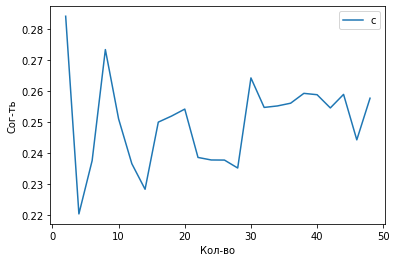

In [111]:
import matplotlib.pyplot as plt
limit=50; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Кол-во")
plt.ylabel("Сог-ть")
plt.legend(("coherence_values"), loc='best')
plt.show()